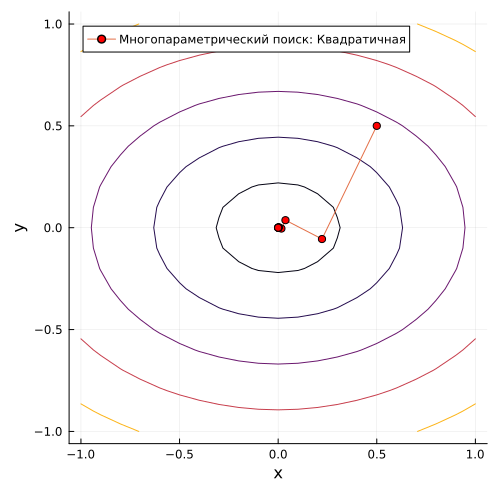

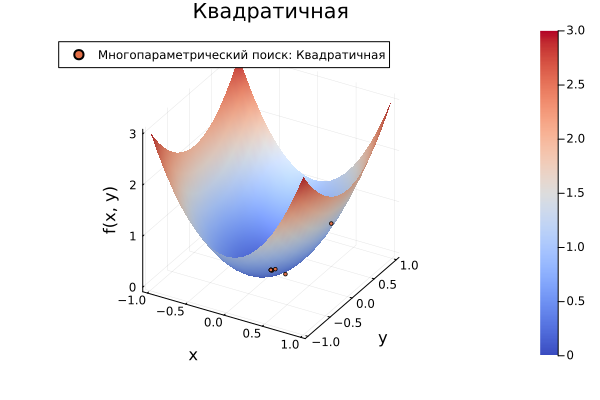

Точка минимума: [1.5049334604507443e-5, 1.5050195593252484e-5]; Количество итераций: 8
Точка минимума: [0.9998912188540501, 0.9997820584883819]; Количество итераций: 821
Точка минимума: [1.262378535038522e-9, 1.262378535038522e-9]; Количество итераций: 1


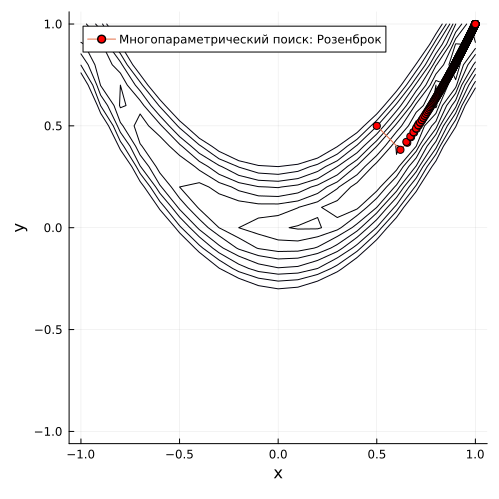

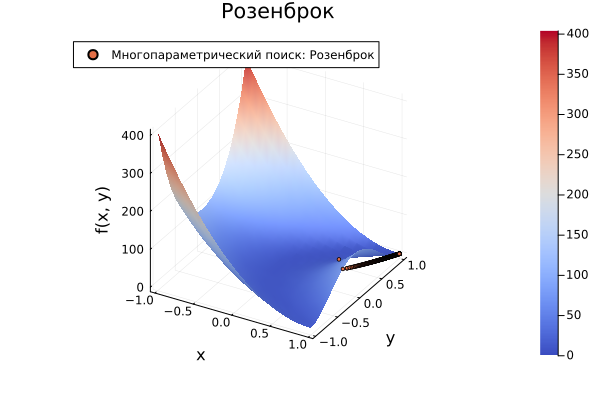

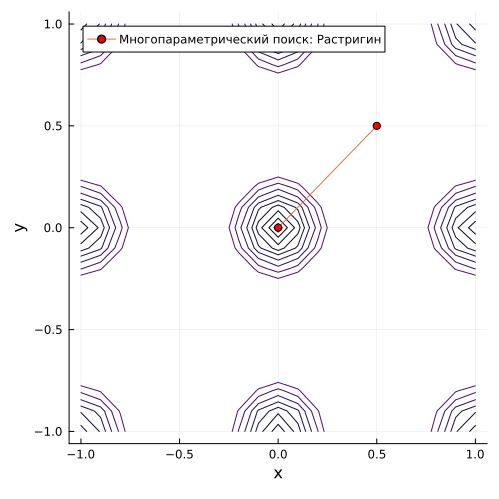

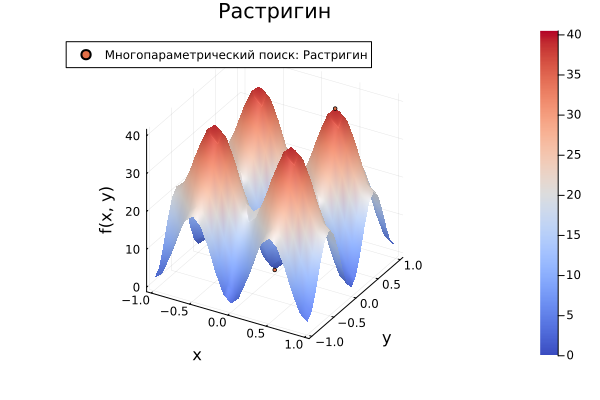

In [8]:
using LinearAlgebra
using Plots

gr()

function df(f, x::Vector{Float64}, i, h=1e-6)
    x_plus = copy(x)
    x_minus = copy(x)
    
    x_plus[i] += h
    x_minus[i] -= h
    
    df_dx = (f(x_plus) - f(x_minus)) / (2h)
    
    return df_dx
end

function gradient(f, x::Vector{Float64})
    grad = []
    for i in 1:length(x)
        push!(grad, df(f, x, i))
    end
    return grad
end
     

function swann_method(f, x0, h=0.1)
    first = x0
    second = x0 + h
    if f(second) > f(first)
        h = -h
        first, second = second, second + h
    end
    last = second + h
    
    while f(last) < f(second)
        h *= 2
        first, second, last = second, last, last + h
    end

    if second > last
        first, second, last = last, second, first
    end

    return first, last
end

function golden_section_search(f, a, b, eps=1e-5)
    phi = (sqrt(5) - 1) / 2 
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    
    while abs(b - a) > eps
        if f(x1) <= f(x2)
            b = x2
        else
            a = x1
        end
        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
    end
    
    return (a + b) / 2
end

function gradient_fast_descent(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    trajectory = [copy(x)]
    
    while true
        grad = gradient(f, x)  
        prev_grad = copy(grad)
        l, r = swann_method(alpha -> f(x - alpha * grad), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * grad), l, r)
        
        x_new = x - alpha * grad

        if norm(x - x_new) < eps1 || norm(f(x) - f(x_new)) < eps2
            break
        end
        
        x = x_new
        push!(trajectory, copy(x))
            
        if dot(prev_grad, gradient(f, x)) > 1
            println("not ortogonal")
        end
    end
    return x, trajectory
end

function reverse_variable_step(f, x, e; Δ0=1.0, β=0.5, tol=1e-6, max_iter=10000)
    α0 = 0.0
    α1 = Δ0
    y0 = f(x + α0 * e)
    y1 = f(x + α1 * e)
    iter_count = 0

    for k in 1:max_iter
        if abs(y0 - y1) < tol
            iter_count = k
            break
        elseif y0 > y1
            α0, y0 = α1, y1
            α1 = α1 + Δ0
            y1 = f(x + α1 * e)
        else
            Δ0 *= -β
            α1 = α0 + Δ0
            y1 = f(x + α1 * e)
        end
    end
    return (α0 + α1) / 2
end

function gauss_seidel(f, x0; tol=1e-6, max_iter=10000)
    x = copy(x0)
    n = length(x)
    iter_count = 0
    iter_vectors = [vcat(x, f(x))]

    for k in 1:max_iter
        x_prev = copy(x)

        for i in 1:n
            e = zeros(n)
            e[i] = 1
            
            α_opt = reverse_variable_step(f, x, e)
            x += α_opt * e
            push!(iter_vectors, vcat(x, f(x)))
        end

        if norm(f(x_prev) - f(x)) < tol
            iter_count = k
            break
        end
    end
    return x, iter_vectors
end

function hooke_jeeves(f, x0; Δ=0.1, β=0.5, tol=1e-6, max_iter=10000)
    x = copy(x0)
    n = length(x)
    Δx = fill(Δ, n)
    iter_count = 0
    iter_vectors = [vcat(x, f(x))]

    while maximum(abs.(Δx)) > tol && iter_count < max_iter
        x_prev = copy(x)
        x_new = copy(x)
        a = 0

        for i in 1:n
            x_test = copy(x_new)
            x_test[i] += Δx[i]
            if f(x_test) < f(x_new)
                x_new = x_test
                push!(iter_vectors, vcat(x_new, f(x_new)))
            else
                x_test[i] = x_new[i] - Δx[i]
                if f(x_test) < f(x_new)
                    x_new = x_test
                    push!(iter_vectors, vcat(x_new, f(x_new)))
                end
            end
        end

        if x_new == x
            Δx *= β
        else
            x = 2 * x_new - x_prev
            if f(x) > f(x_new)
                x = x_new
            end
        end

        iter_count += 1
    end
    return x, iter_vectors
end

function conjugate_gradient(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    grad = gradient(f, x)
    d = -grad
    trajectory = [x]
    
    while true
        prev_grad=copy(grad)
        l, r = swann_method(alpha -> f(x + alpha * d), 1e-7)
        alpha = golden_section_search(alpha -> f(x + alpha * d), l, r)
        x += alpha * d
        grad = gradient(f, x)

        if norm(x - prev_x) < eps1 || norm(f(x) - f(prev_x)) < eps2
            break
        end

        beta = dot(grad, grad) / dot(prev_grad, prev_grad)
        d = -grad + beta * d
        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

function krejci_leva_search(f, x0, m_max)
    eps1 = 1e-4
    x = x0
    prev_x = copy(x)
    trajectory = [x]
    n = length(x)
    i = 0
    m = min(m_max, n - 1)

    delta_list = Vector{Vector{Float64}}()

    while true        
        i += 1
        grad = gradient(f, x)

        pushfirst!(delta_list, x - prev_x)
        if length(delta_list) > m
            pop!(delta_list)
        end
        
        g = λ -> begin
            step = -λ[1] * grad
            if !isempty(delta_list)
                step += sum(λ[i+1] * delta_list[i] for i in 1:length(delta_list))
            end
            f(x + step)
        end
        
        λ_k, _ = hooke_jeeves(g, zeros(length(delta_list) + 1))
        
        x_new = x - λ_k[1] * grad
        if !isempty(delta_list)
            x_new += sum(λ_k[i+1] * delta_list[i] for i in 1:length(delta_list))
        end
        
        prev_x = copy(x)
        x = x_new
        push!(trajectory, x)
        
        if norm(gradient(f, x)) < eps1
            break
        end
    end
    
    return x, trajectory
end

function quadratic(x; a=1.0, b=2.0)
    return a * (x[1])^2 + b * (x[2])^2
end

function rosenbrock(x)
    return (1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2
end

function schwefel(x)
    return 418.9829 * 2 - (x[1] * sin(sqrt(abs(x[1]))) + x[2] * sin(sqrt(abs(x[2]))))
end

function rastrigin(x)
    return 20 + sum(x.^2 .- 10 * cos.(2 * π * x))
end

function plot_function_contours(f, func_name)
    x0 = [0.5, 0.5]
    x = -1:0.1:1
    y = -1:0.1:1
    levels = []
    for i in 1:10
        push!(levels, i^2*0.1)
    end

    x_min, trajectory = krejci_leva_search(f, x0, 0)
    println("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

    x_coords = [point[1] for point in trajectory]
    y_coords = [point[2] for point in trajectory]

    p0 = Plots.contour(x, y, (x, y) -> f([x, y]), levels = levels, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
    plot!(p0, x_coords, y_coords, label="Многопараметрический поиск: $func_name", marker=:red)
    
    display(p0)

    z = [f([xi, yi]) for xi in x, yi in y]

    p3d1 = Plots.surface(x, y, z, xlabel="x", ylabel="y", zlabel="f(x, y)", title=func_name, color=:coolwarm)

    plot!(p3d1, x_coords, y_coords, [f([x, y]) for (x, y) in zip(x_coords, y_coords)], 
          seriestype=:scatter3d, label="Многопараметрический поиск: $func_name", linecolor=:red, markersize=2, marker=:circle)
          
    display(p3d1)
end

plot_function_contours(quadratic, "Квадратичная")
plot_function_contours(rosenbrock, "Розенброк")
# plot_function_contours(schwefel, "Швефель")
plot_function_contours(rastrigin, "Растригин")
    